## Выделение подгрупп с определенным ctr  и cvr. Применение статистических методов для ответов на некоторые вопросы.

Была проведена пилотная рекламная кампания, по ее результатам собраны логи. Перед запуском основных РК рекламодатель хочет решить несколько задач. 
 
Для оценки эффективности бизнес использует 2 показателя
ctr = количество кликов / количество показов
cvr = количество юзеров, которые совершили конверсию / количество юзеров, которые перешли на сайт (кликнули)
 
Задачи:
Выделить подгруппы аудитории по соцдем и поведенческим признакам, для которой выборочная оценка ctr была бы не ниже 0.85%. Выбрать такие подгруппы
Выделить подгруппы аудитории по соцдем и поведенческим признакам, для которой выборочная оценка cvr была бы не ниже 45%. 
 
Далее можно выбрать по 1 из подгрупп:
   - значимо ли выше ctr для подгруппы аудитории, чем среди всего датасета охваченных РК?
   - значимо ли выше cvr для подгруппы аудитории, чем среди всего датасета охваченных РК?
   - какой будет размер эффекта для ctr если сравнивать выбранную подгруппу со всеми остальными юзерами (не с тоталом)
   - какой будет размер эффекта для cvr если сравнивать выбранную подгруппу со всеми остальными юзерами (не с тоталом)
   - рекламодатель скептик и ожидает минимальных изменений по сравнению с остальными юзерами:  он просит посчитать доверительный интервал для размера эффекта и указать его нижнюю границу для ctr и cvr

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.impute import KNNImputer
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import t

In [2]:
data = pd.read_csv('data_test_task_da.csv', sep='\t')

In [3]:
data[:5]

,user_id,imp_id,ev_type,date,age,gender,family_status,employment_status,personal_income,temperament
0,31053,1,1,dt1,48.0,1.0,44.0,26.0,41.0,NaN
1,78689,1,7,dt3,17.0,0.0,NaN,NaN,NaN,NaN
2,143516,1,0,dt4,15.0,0.0,44.0,27.0,39.0,NaN
3,116742,2,0,dt4,NaN,0.0,44.0,27.0,38.0,NaN
4,140422,3,0,dt8,57.0,0.0,44.0,26.0,40.0,NaN


In [4]:
#посмотрим на топ значения
data[['imp_id', 'user_id','ev_type','date', 'age', 'gender', 'family_status', 'employment_status','personal_income','temperament']].astype(object).describe(include='object')

,imp_id,user_id,ev_type,date,age,gender,family_status,employment_status,personal_income,temperament
count,260716,260716,260716,260716,240979.0,241731.0,163757.0,163882.0,163224.0,37000.0
unique,258095,147251,3,8,72.0,2.0,2.0,2.0,5.0,4.0
top,1,54101,0,dt2,17.0,1.0,44.0,26.0,39.0,197.0
freq,3,45,257966,45149,11226.0,147513.0,115144.0,88038.0,66817.0,17612.0


In [5]:
#сколько нанов в каждой колонке
data.isnull().sum()

user_id                   0
imp_id                    0
ev_type                   0
date                      0
age                   19737
gender                18985
family_status         96959
employment_status     96834
personal_income       97492
temperament          223716
dtype: int64

In [6]:
#пропущенных колонок слишком много, воспользуемся KNNImputer, чтобы их заполнить

#для начала колонку date переведем в вещественное значение
data['date'] = data['date'].str[-1].astype(float)

#посчитаем KNNImputer на 2 соседях
imputer = KNNImputer(n_neighbors=2)
imputer.fit(data.sample(5000, random_state=42))
data_imputer = imputer.transform(data)

data_imputer = pd.DataFrame(data_imputer)
data_imputer.columns = data.columns

In [7]:
data_imputer[:5]

,user_id,imp_id,ev_type,date,age,gender,family_status,employment_status,personal_income,temperament
0,31053.0,1.0,1.0,1.0,48.0,1.0,44.0,26.0,41.0,196.5
1,78689.0,1.0,7.0,3.0,17.0,0.0,43.0,26.0,39.5,196.0
2,143516.0,1.0,0.0,4.0,15.0,0.0,44.0,27.0,39.0,197.5
3,116742.0,2.0,0.0,4.0,25.0,0.0,44.0,27.0,38.0,196.0
4,140422.0,3.0,0.0,8.0,57.0,0.0,44.0,26.0,40.0,197.5


In [8]:
#ctr и cvr в датасете
def ctr_function(data):
    return len(data[data["ev_type"] == 1]) / len(data[data["ev_type"] == 0]) * 100

def cvr_function(data):
    return len(data[data["ev_type"] == 7]) / len(data[data["ev_type"] == 1]) * 100

ctr_data = ctr_function(data)
cvr_data = cvr_function(data)

print(f'CTR в изначальной выборке = {ctr_data}')
print(f'CVR в изначальной выборке = {cvr_data}')

CTR в изначальной выборке = 0.7780095051285829
CVR в изначальной выборке = 37.02042850024913


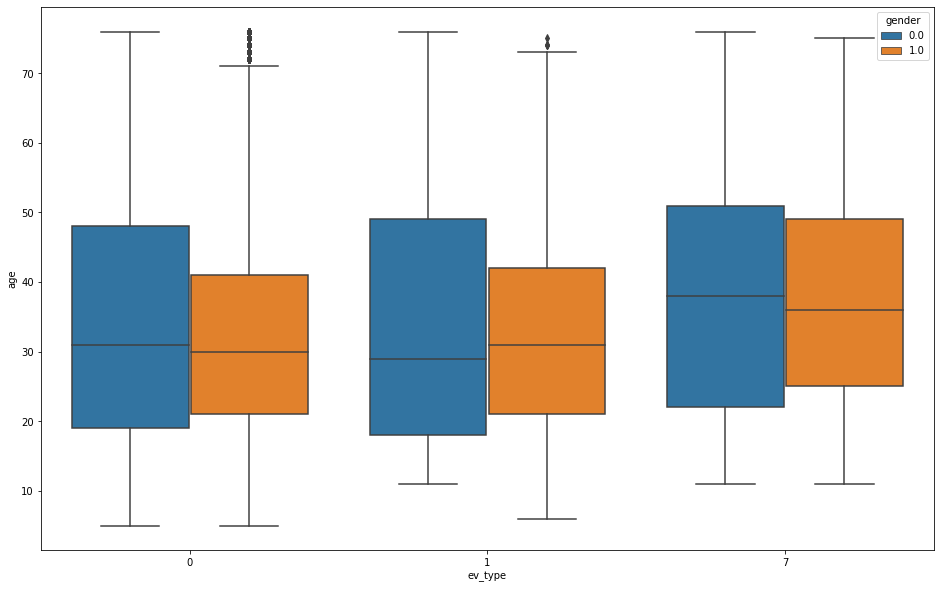

In [11]:
#распределение возраста по действию
fig = plt.figure()
fig.set_size_inches(16, 10)
    
sns.boxplot(y='age', x=data['ev_type'].astype('category'), data=data, hue="gender")
plt.show()

#в целом, интересно, что чаще конверсию совершают люди постарше (медиана у 7 типа на уровне ~age=38)

## 1. Выделение подгрупп

In [12]:
def calculate_ctr_cvr_group(group):
    d = {}
    total_impressions = len(group[group['ev_type'] == 0])
    total_clicks = len(group[group['ev_type'] == 1])
    total_conversions = len(group[group['ev_type'] == 7])
    
    ctr = ctr_function(group) if total_impressions != 0 else 0
    cvr = cvr_function(group) if total_clicks != 0 else 0
    unique_users = group['user_id'].nunique()
    
    d['ctr'] = ctr
    d['cvr'] = cvr
    d['unique_users'] = unique_users
    return pd.Series(d, index=['ctr', 'cvr', 'unique_users'])

In [13]:
# посмотрим на подвыборки с ctr > 0.85 и количеством людей больше 500
ctr_cvr_data = data_imputer.groupby(['age', 'gender', 'family_status', 'personal_income']).apply(calculate_ctr_cvr_group)
ctr_cvr_data[(ctr_cvr_data['ctr'] > 0.85) & (ctr_cvr_data['unique_users'] > 500)]

ctr        cvr  unique_users
age  gender family_status personal_income                                   
15.0 1.0    44.0          40.0             1.317829  35.294118         705.0
16.0 0.0    44.0          40.0             1.224490  20.000000         639.0
17.0 0.0    44.0          38.0             0.916031   0.000000         670.0
                          39.0             0.942350  29.411765        1039.0
18.0 0.0    44.0          39.0             1.031814  25.000000         703.0
     1.0    44.0          39.0             1.047443  23.529412        1054.0
19.0 0.0    44.0          38.0             0.962861   0.000000         883.0
                          39.0             0.872818  14.285714         527.0
20.0 0.0    44.0          38.0             1.373283  13.636364         913.0
22.0 1.0    44.0          39.0             1.032205  20.000000        1614.0
23.0 1.0    44.0          39.0             0.939746  17.647059        1188.0
27.0 1.0    44.0          39.0             0.987092  15.384615         861.0
30.0 1.0    44.0          39.0             1.064963  50.000000         564.0

In [14]:
# посмотрим на подвыборки с cvr > 0.85 и количеством людей больше 500
ctr_cvr_data[(ctr_cvr_data['cvr'] > 45) & (ctr_cvr_data['unique_users'] > 500)]

,,,,ctr,cvr,unique_users
age,gender,family_status,personal_income,,,
19.0,1.0,44.0,38.0,0.638162,50.000000,919.0
22.0,0.0,44.0,38.0,0.785024,46.153846,994.0
30.0,1.0,44.0,39.0,1.064963,50.000000,564.0
32.0,1.0,44.0,39.0,0.405680,50.000000,614.0


In [15]:
#выбираем подгруппу с высочайшеми показателями ctr и cvr
data_clustering_ctr = data_imputer[(data_imputer['age'] == 20) & (data_imputer['gender'] == 0.0) & (data_imputer['family_status'] == 44.0) & (data_imputer['personal_income'] == 38.0)]
data_clustering_cvr = data_imputer[(data_imputer['age'] == 19) & (data_imputer['gender'] == 1.0) & (data_imputer['family_status'] == 44.0) & (data_imputer['personal_income'] == 38.0)]

#### Значимо ли выше ctr подгруппы, чем для всей выборки?

In [16]:
# посчитаем через распределение Бернулли, так как в ctr считаются два 
# действия: клик и просмотр

def bernulli_ctr(data_ctr, alpha, data = data):
    #количество кликов в подгруппе и датасете
    count = [len(data_ctr[data_ctr['ev_type'] == 1]), len(data[data['ev_type'] == 1])]

    #количество просмотров в подгруппе и датасете
    nobs = [len(data_ctr[data_ctr['ev_type'] == 0]), len(data[data['ev_type'] == 0])]

    # нулевая гипотеза, что в среднем кликов в подгруппе меньше, чем в датасете
    # альтернативная - что больше
    stat, pval = proportions_ztest(count, nobs, alternative='larger')

    if pval < alpha:
        print(f'Есть основания отвергнуть нулевую гипотезу, p-value = {pval}, значит различия значимы')
    else:
        print(f'Нет оснований отвергнуть нулевую гипотезу, p-value = {pval}, значит различия незначимы')

In [17]:
bernulli_ctr(data_clustering_ctr, 0.05)

Есть основания отвергнуть нулевую гипотезу, p-value = 0.003497618011634284, значит различия значимы


#### Значимо ли выше cvr подгруппы, чем для всей выборки?

In [18]:
# посчитаем через распределение Бернулли, так как в cvr считаются два 
# действия: клик и конверсия

def bernulli_cvr(data_cvr, alpha, data = data):
    #количество кликов в подгруппе и датасете
    count = [len(data_cvr[data_cvr['ev_type'] == 7]), len(data[data['ev_type'] == 7])]

    #количество просмотров в подгруппе и датасете
    nobs = [len(data_cvr[data_cvr['ev_type'] == 1]), len(data[data['ev_type'] == 1])]

    # нулевая гипотеза, что в среднем кликов в подгруппе меньше, чем в датасете
    # альтернативная - что больше
    stat, pval = proportions_ztest(count, nobs, alternative='larger')

    if pval < alpha:
        print(f'Есть основания отвергнуть нулевую гипотезу, p-value = {pval}, значит различия значимы')
    else:
        print(f'Нет оснований отвергнуть нулевую гипотезу, p-value = {pval}, значит различия незначимы')

In [19]:
bernulli_cvr(data_clustering_cvr, 0.05)

Нет оснований отвергнуть нулевую гипотезу, p-value = 0.19832254104751923, значит различия незначимы


#### Размер эффекта ctr и cvr подгруппы от остальных людей; Нижняя граница доверительного интвервала для размера эффекта

In [20]:
#записываем людей из общего датасета, но только тех, которые не входят в подгруппу
data_without_clustering_ctr = data[~data['user_id'].isin (data_clustering_cvr.user_id.unique())]
data_without_clustering_cvr = data[~data['user_id'].isin (data_clustering_cvr.user_id.unique())]

Размер эффекта и нижняя граница доверительного интвервала для ctr:

In [21]:
def size_effect_and_confidence_interval_ctr(data_ctr, data_without, alpha):
    s1 = np.var(data_without[data_without['ev_type']!=7].ev_type)/len(data_without)
    s2 = np.var(data_ctr[data_ctr['ev_type']!=7].ev_type)/len(data_ctr)
    se = (s1 + s2)**(1/2)

    m1 = np.mean(data_without[data_without['ev_type']!=7].ev_type)
    m2 = np.mean(data_ctr[data_ctr['ev_type']!=7].ev_type)
    d = (m2 - m1)/se
    
    t_alpha = t.ppf(q=1-alpha/2, df = len(data_without) + len(data_ctr) - 2)
    
    print(f'Размер эффекта для ctr = {d}')
    print(f'Нижний доверительный 95% интервал для размера эффекта = {d - t_alpha * se}')

In [22]:
size_effect_and_confidence_interval_ctr(data_clustering_ctr, data_without_clustering_ctr, 0.05)

Размер эффекта для ctr = 2.0268728096327937
Нижний доверительный 95% интервал для размера эффекта = 2.0212455819743633


Размер эффекта и нижняя граница доверительного интвервала для cvr:

In [23]:
def size_effect_and_confidence_interval_cvr(data_cvr, data_without, alpha):
    s1 = np.var(data_without[data_without['ev_type']!=0].ev_type)/len(data_without)
    s2 = np.var(data_cvr[data_cvr['ev_type']!=0].ev_type)/len(data_cvr)
    se = (s1 + s2)**(1/2)

    m1 = np.mean(data_without[data_without['ev_type']!=0].ev_type)
    m2 = np.mean(data_cvr[data_cvr['ev_type']!=0].ev_type)
    d = (m2 - m1)/se
    
    t_alpha = t.ppf(q=1-alpha/2, df = len(data_without) + len(data_cvr) - 2)

    print(f'Размер эффекта для cvr = {d}')
    print(f'Нижний доверительный 95% интервал для размера эффекта = {d - t_alpha * se}')

In [24]:
size_effect_and_confidence_interval_cvr(data_clustering_cvr, data_without_clustering_cvr, 0.05)

Размер эффекта для cvr = 5.3489956749334535
Нижний доверительный 95% интервал для размера эффекта = 5.209241469232512


## 2. Кластеризация

### 2.1 KMeans кластеризация

In [25]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_imputer[['age', 'gender', 'family_status', 'employment_status', 'personal_income', 'temperament']])

#посчитаем kmeans с разными количествами классов
for i in range(3,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)

    #добавим лейбл класса в датасет
    data_clustering_kmeans = data_imputer
    data_clustering_kmeans['Cluster'] = clusters
    
    #считаем ctr и cvr для каждой подгруппы
    data_clustering_kmeans = data_clustering_kmeans.groupby(['Cluster']).apply(calculate_ctr_cvr_group)
    
    #выведем только те подгруппы, у которых ctr и cvr выше 0.85 и 45 соответственно     
    print(i , data_clustering_kmeans.loc[(data_clustering_kmeans['ctr'] > 0.85) |  (data_clustering_kmeans['cvr'] > 45)], '\n')


3               ctr        cvr  unique_users
Cluster                                   
2        0.732411  46.902655       39819.0 

4               ctr        cvr  unique_users
Cluster                                   
0        0.734154  47.099768       37587.0
3        0.852820  31.450382       43975.0 

5               ctr        cvr  unique_users
Cluster                                   
1        0.856138  26.710817       30767.0
3        0.847599  48.355263       20410.0
4        0.731124  45.646438       33578.0 

6               ctr        cvr  unique_users
Cluster                                   
2        0.788340  55.121951       15022.0
5        0.872265  25.000000       25008.0 

7               ctr        cvr  unique_users
Cluster                                   
1        0.775890  56.315789       14045.0
6        0.900277  30.769231       20244.0 

8               ctr        cvr  unique_users
Cluster                                   
3        0.702644  45.643154    

In [26]:
#Возьмем подгруппы с максимальным ctr и cvr 


#ctr выше в kmeans с 10 классами в 3 кластере
kmeans = KMeans(n_clusters=10, max_iter = 300, n_init = 10, random_state=42, init = 'k-means++',)
clusters = kmeans.fit_predict(scaled_data)

data_clustering_kmeans_ctr = data_imputer
data_clustering_kmeans_ctr['Cluster'] = clusters
data_clustering_kmeans_ctr = data_clustering_kmeans_ctr[data_clustering_kmeans_ctr['Cluster'] == 3]


#cvr выше в kmeans с 10 классами в 9 кластере
kmeans = KMeans(n_clusters=10, max_iter = 300, n_init = 10, random_state=42, init = 'k-means++',)
clusters = kmeans.fit_predict(scaled_data)

data_clustering_kmeans_cvr = data_imputer
data_clustering_kmeans_cvr['Cluster'] = clusters
data_clustering_kmeans_cvr = data_clustering_kmeans_cvr[data_clustering_kmeans_cvr['Cluster'] == 9]

#### Значимо ли выше ctr подгруппы, чем для всей выборки?

In [27]:
bernulli_ctr(data_clustering_kmeans_ctr, 0.05)

Есть основания отвергнуть нулевую гипотезу, p-value = 0.003892541249273844, значит различия значимы


#### Значимо ли выше cvr подгруппы, чем для всей выборки?

In [28]:
bernulli_cvr(data_clustering_kmeans_cvr, 0.05)

Есть основания отвергнуть нулевую гипотезу, p-value = 1.2623936084668133e-09, значит различия значимы


#### Размер эффекта ctr и cvr подгруппы от остальных людей; Нижняя граница доверительного интвервала для размера эффекта

In [29]:
#записываем людей из общего датасета, но только тех, которые не входят в подгруппу
data_without_ctr_kmeans = data[~data['user_id'].isin (data_clustering_kmeans_ctr.user_id.unique())]
data_without_cvr_kmeans = data[~data['user_id'].isin (data_clustering_kmeans_cvr.user_id.unique())]

Размер эффекта и нижняя граница доверительного интвервала для ctr:

In [30]:
size_effect_and_confidence_interval_ctr(data_clustering_kmeans_ctr, data_without_ctr_kmeans, 0.05)

Размер эффекта для ctr = 2.7147302622689247
Нижний доверительный 95% интервал для размера эффекта = 2.7134828540860063


Размер эффекта и нижняя граница доверительного интвервала для cvr:

In [31]:
size_effect_and_confidence_interval_cvr(data_clustering_kmeans_cvr, data_without_cvr_kmeans, 0.05)

Размер эффекта для cvr = 31.163635100515005
Нижний доверительный 95% интервал для размера эффекта = 31.113192470796648


### 2.2 Birch кластеризация

In [32]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_imputer[['age', 'gender', 'family_status', 'employment_status', 'personal_income', 'temperament']])

#посчитаем Birch
birch = Birch(n_clusters=10)
clusters = birch.fit_predict(scaled_data)

#добавим лейбл класса в датасет
data_clustering_birch = data_imputer
data_clustering_birch['Cluster'] = clusters

In [33]:
data_clustering_birch.groupby(['Cluster']).apply(calculate_ctr_cvr_group)

,ctr,cvr,unique_users
Cluster,,,
0,0.841940,50.581395,14048.0
1,0.761576,26.208178,48593.0
2,0.781909,38.636364,16545.0
3,0.865570,49.230769,10269.0
4,0.793797,34.105960,25228.0
5,0.711337,40.740741,8731.0
6,0.807891,38.674033,15519.0
7,0.933925,47.500000,3194.0
8,0.708426,38.064516,31443.0


In [34]:
data_clustering_birch_ctr = data_clustering_birch[data_clustering_birch['Cluster'] == 7]
data_clustering_birch_cvr = data_clustering_birch[data_clustering_birch['Cluster'] == 9]

#### Значимо ли выше ctr подгруппы, чем для всей выборки?

In [35]:
bernulli_ctr(data_clustering_birch_ctr, 0.05)

Нет оснований отвергнуть нулевую гипотезу, p-value = 0.12507799463983277, значит различия незначимы


#### Значимо ли выше cvr подгруппы, чем для всей выборки?

In [36]:
bernulli_cvr(data_clustering_birch_cvr, 0.05)

Есть основания отвергнуть нулевую гипотезу, p-value = 0.003974445656204952, значит различия значимы


#### Размер эффекта ctr и cvr подгруппы от остальных людей; Нижняя граница доверительного интвервала для размера эффекта

In [37]:
#записываем людей из общего датасета, но только тех, которые не входят в подгруппу
data_without_ctr_birch = data[~data['user_id'].isin (data_clustering_birch_ctr.user_id.unique())]
data_without_cvr_birch = data[~data['user_id'].isin (data_clustering_birch_cvr.user_id.unique())]

Размер эффекта и нижняя граница доверительного интвервала для ctr:

In [38]:
size_effect_and_confidence_interval_ctr(data_clustering_birch_ctr, data_without_ctr_birch, 0.05)

Размер эффекта для ctr = 1.0756219784793672
Нижний доверительный 95% интервал для размера эффекта = 1.072753724070773


Размер эффекта и нижняя граница доверительного интвервала для cvr:

In [39]:
size_effect_and_confidence_interval_cvr(data_clustering_birch_cvr, data_without_cvr_birch, 0.05)

Размер эффекта для cvr = 16.24366088723013
Нижний доверительный 95% интервал для размера эффекта = 16.185788823667817


### 2.3 DBSCAN кластеризация

In [40]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_imputer[['age', 'gender', 'family_status', 'employment_status', 'personal_income', 'temperament']])

pairs_of_hyperparams = [
                            [0.1,20],
                            [0.1,50],
                            [0.2,20],
                            [0.2,50],
                            [0.3,20],
                            [0.3,50],
                       ]

for i, s in enumerate(pairs_of_hyperparams):
    
    dbscan = DBSCAN(eps=s[0], min_samples=s[1]).fit(scaled_data)
    clusters = dbscan.fit_predict(scaled_data)
    
    #добавим лейбл класса в датасет
    data_clustering_dbscan = data_imputer
    data_clustering_dbscan['Cluster'] = clusters
    
    #считаем ctr и cvr для каждой подгруппы
    data_clustering_dbscan = data_clustering_dbscan.groupby(['Cluster']).apply(calculate_ctr_cvr_group)
    
    #выведем только те подгруппы, у которых ctr и cvr выше 0.85 и 45 соответственно и уникальных пользователей больше 5000  
    print(i , data_clustering_dbscan.loc[(data_clustering_dbscan['unique_users'] > 5000) & ((data_clustering_dbscan['ctr'] > 0.85) |  (data_clustering_dbscan['cvr'] > 45))], '\n')

0               ctr        cvr  unique_users
Cluster                                   
4        0.822889  46.153846        5406.0 

1               ctr        cvr  unique_users
Cluster                                   
2        0.824455  46.153846        5393.0 

2               ctr        cvr  unique_users
Cluster                                   
4        0.822681  46.153846        5408.0 

3               ctr        cvr  unique_users
Cluster                                   
2        0.822889  46.153846        5406.0 

4               ctr        cvr  unique_users
Cluster                                   
6        0.820707  46.153846        5426.0 

5               ctr        cvr  unique_users
Cluster                                   
4        0.821537  46.153846        5419.0 



In [41]:
#для ctr > 0.85 и с 5000 уникальными пользователями dbscan не нашел кластеров
#поэтому считаем только для cvr

#cvr во всех кластерах одинаковый, поэтому возьмем с первыми параметрами
dbscan = DBSCAN(eps=0.1, min_samples=20)
clusters = dbscan.fit_predict(scaled_data)

data_clustering_dbscan_cvr = data_imputer
data_clustering_dbscan_cvr['Cluster'] = clusters
data_clustering_dbscan_cvr = data_clustering_dbscan_cvr[data_clustering_dbscan_cvr['Cluster'] == 4]

#### Значимо ли выше cvr подгруппы, чем для всей выборки?

In [42]:
bernulli_cvr(data_clustering_dbscan_cvr, 0.05)

Нет оснований отвергнуть нулевую гипотезу, p-value = 0.06699834255498227, значит различия незначимы


#### Размер эффекта ctr и cvr подгруппы от остальных людей; Нижняя граница доверительного интвервала для размера эффекта

In [43]:
#записываем людей из общего датасета, но только тех, которые не входят в подгруппу
data_without_cvr_dbscan = data[~data['user_id'].isin (data_clustering_dbscan_cvr.user_id.unique())]

Размер эффекта и нижняя граница доверительного интвервала для cvr:

In [44]:
size_effect_and_confidence_interval_cvr(data_clustering_dbscan_cvr, data_without_cvr_dbscan, 0.05)

Размер эффекта для cvr = 9.001244996524548
Нижний доверительный 95% интервал для размера эффекта = 8.939216522076318
